# Importar librerías

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
from PIL import Image
import random
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from torch_geometric.nn import GCNConv
import math
from torchvision.models import DenseNet121_Weights
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper functions

## Función para reservar parte del fichero de muestras para test

In [2]:
def dividir_csv(fichero_entrada, fichero_salida1, fichero_salida2, porcentaje=70):
    """
    Divide un archivo CSV en dos archivos en función de un porcentaje.

    :param fichero_entrada: Ruta del archivo CSV de entrada.
    :param fichero_salida1: Ruta del primer archivo CSV de salida.
    :param fichero_salida2: Ruta del segundo archivo CSV de salida.
    :param porcentaje: Porcentaje de datos que debe ir al primer archivo (0-100).
    """
    # Asegurar que el porcentaje está entre 0 y 100
    if porcentaje < 0 or porcentaje > 100:
        raise ValueError("El porcentaje debe estar entre 0 y 100.")

    with open(fichero_entrada, mode='r', newline='') as f_entrada:
        lector_csv = list(csv.reader(f_entrada))
        
        # Obtener el encabezado y los datos
        encabezado = lector_csv[0]
        datos = lector_csv[1:]
        
        # Mezclar aleatoriamente las filas
        random.shuffle(datos)

        # Calcular el número de filas para cada archivo
        total_filas = len(datos)
        num_filas_salida1 = int(total_filas * porcentaje / 100)
        
        # Separar los datos
        datos_salida1 = datos[:num_filas_salida1]
        datos_salida2 = datos[num_filas_salida1:]

        # Escribir el primer archivo CSV
        with open(fichero_salida1, mode='w', newline='') as f_salida1:
            escritor_csv1 = csv.writer(f_salida1)
            escritor_csv1.writerow(encabezado)
            escritor_csv1.writerows(datos_salida1)

        # Escribir el segundo archivo CSV
        with open(fichero_salida2, mode='w', newline='') as f_salida2:
            escritor_csv2 = csv.writer(f_salida2)
            escritor_csv2.writerow(encabezado)
            escritor_csv2.writerows(datos_salida2)


## Data Loader

In [3]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Grayscale(),  # Convertir a blanco y negro
    transforms.Resize((96, 96)),  # Ajustar el tamaño si es necesario
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliza a [-1, 1]
])

# Función para cargar las etiquetas desde un archivo CSV
def load_labels(csv_path,frac=1):
    df_1 = pd.read_csv(csv_path)
    df=df_1.sample(frac=frac)
    labels = {row['id']: row['label'] for _, row in df.iterrows()}
    return labels



# Dataset personalizado
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        '''
        # Filtrar solo las imágenes que existen
        self.img_ids = [img_id for img_id in labels.keys() if os.path.exists(os.path.join(img_dir, f'{img_id}.png'))]
        '''
        self.img_ids = list(labels.keys())  # Utilizamos todas las claves de etiquetas
        
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.img_dir, f'{img_id}.tif')
        
        # Cargar la imagen
        image = Image.open(img_path).convert('RGB')
        label = self.labels[img_id]

        if self.transform:
            image = self.transform(image)

        return image, label

## Entrenamiento

Se implementa el entrenamiento mediante validación cruzada y con un callback para detener el entrenamiento con una paciencia de 5 épocas

In [4]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=30, batch_size=32, learning_rate=0.001, patience=5, l1_lambda=1e-5, l2_lambda=1e-4):
    # Device (CPU or GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Split the dataset into training and validation (80% training, 20% validation)
    total_size = len(train_loader.dataset)
    val_size = int(0.2 * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(train_loader.dataset, [train_size, val_size])

    # DataLoader for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # To store losses and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Early Stopping variables
    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Model training
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Reset gradients
            optimizer.zero_grad()
            
            # Forward pass and loss calculation
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # L1 regularization
            l1_reg = torch.tensor(0., requires_grad=True)
            for param in model.parameters():
                l1_reg = l1_reg + torch.norm(param, 1)
            loss = loss + l1_lambda * l1_reg

            # L2 regularization (in addition to weight decay in optimizer)
            l2_reg = torch.tensor(0., requires_grad=True)
            for param in model.parameters():
                l2_reg = l2_reg + torch.norm(param, 2)
            loss = loss + l2_lambda * l2_reg
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate loss and accuracy per epoch for the training set
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Model validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Accumulate loss
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate loss and accuracy per epoch for the validation set
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Learning rate scheduler
        scheduler.step(val_loss)

        # Print results per epoch
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        # Early Stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Stopping training early at epoch {epoch+1} due to lack of improvement in validation accuracy.')
            break

    # Plot the evolution of loss and accuracy
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Evolution')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

## Evaluación

In [5]:
# Función para evaluar el modelo
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Asegurarse de que el modelo está en el dispositivo correcto
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    
    return all_labels, all_preds



In [6]:
# Función para realizar predicción en una sola imagen
def predict_image(image_path,model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with Image.open(image_path) as image:
        image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
    _, predicted = torch.max(output, 1)
    return predicted.item()


# Modelos

## Modelo basado en RestNet y Red Neuronal Gráfica GCC

In [7]:
class CNNGNN(nn.Module):
    def __init__(self, num_gnn_layers=2, num_neurons_fc=256, num_classes=2, dropout_rate=0.5):
        super(CNNGNN, self).__init__()
        
        # Cargar DenseNet-121 preentrenada
        self.densenet = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        
        # Modificar la primera capa si es necesario para aceptar imágenes con 1 canal
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Congelar algunos parámetros de DenseNet
        for param in list(self.densenet.parameters())[:-5]:
            param.requires_grad = False
        
        # Calcular el tamaño de salida de DenseNet
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 96, 96)
            densenet_output = self.densenet.features(dummy_input)
            self.densenet_output_shape = densenet_output.shape
            
        # Ajustar las dimensiones para GNN
        self.gnn_input_dim = self.densenet_output_shape[1]  # Número de canales de salida de DenseNet
        self.gnn_output_dim = 256
        
        # Crear las capas GNN
        self.gnn_layers = nn.ModuleList([GCNConv(self.gnn_input_dim if i == 0 else self.gnn_output_dim, 
                                                 self.gnn_output_dim) 
                                         for i in range(num_gnn_layers)])
        
        # Crear las capas completamente conectadas
        self.fc = nn.Sequential(
            nn.Linear(self.gnn_output_dim, num_neurons_fc),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(num_neurons_fc, num_neurons_fc // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(num_neurons_fc // 2, num_classes)
        )
        
        # Agregar BatchNorm después de las capas GNN
        self.bn = nn.BatchNorm1d(self.gnn_output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        
        # Parte CNN
        x = self.densenet.features(x)
        
        # Reshape para GNN
        x = x.view(batch_size, self.gnn_input_dim, -1)  # [batch_size, channels, height * width]
        
        # Crear la estructura de grafo
        num_nodes = x.size(2)
        edge_index = self.create_grid_graph(int(math.sqrt(num_nodes)))
        edge_index = edge_index.to(x.device)
        
        # Parte GNN
        for i, gnn_layer in enumerate(self.gnn_layers):
            x = x.permute(0, 2, 1).contiguous()  # [batch_size, nodes, features]
            x = torch.stack([gnn_layer(x[i], edge_index) for i in range(batch_size)])
            x = x.permute(0, 2, 1).contiguous()  # [batch_size, features, nodes]
        
        # Global average pooling
        x = torch.mean(x, dim=2)
        
        # Aplicar BatchNorm
        x = self.bn(x)
        
        # Capas completamente conectadas
        x = self.fc(x)
        
        return x

    @staticmethod
    def create_grid_graph(size):
        edge_index = []
        for i in range(size):
            for j in range(size):
                if i > 0:
                    edge_index.append([i * size + j, (i - 1) * size + j])
                if i < size - 1:
                    edge_index.append([i * size + j, (i + 1) * size + j])
                if j > 0:
                    edge_index.append([i * size + j, i * size + (j - 1)])
                if j < size - 1:
                    edge_index.append([i * size + j, i * size + (j + 1)])
        return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Implementación 

In [8]:
try:
    os.chdir('prueba_us')
except:
    pass

In [9]:
# Reservar el 10% de los datos para test
dividir_csv("train_labels.csv", "train.csv", "test.csv", porcentaje=90)

In [10]:
# Cargar los datasets
batch_size=128
# Cargar las etiquetas
train_labels = load_labels('train.csv')
train_dataset = CustomImageDataset(img_dir='train', labels=train_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

# Cargar etiquetas de prueba (si las necesitas para evaluación)
test_labels = load_labels('test.csv')
test_dataset = CustomImageDataset(img_dir='train', labels=test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)

## Implementación híbrida CNN-GNN

Epoch 1/100, Training Loss: 1.9507, Training Accuracy: 79.52%, Validation Loss: 0.4268, Validation Accuracy: 80.38%
Epoch 2/100, Training Loss: 1.8765, Training Accuracy: 80.37%, Validation Loss: 0.4240, Validation Accuracy: 80.59%
Epoch 3/100, Training Loss: 1.8484, Training Accuracy: 80.66%, Validation Loss: 0.4228, Validation Accuracy: 80.90%
Epoch 4/100, Training Loss: 1.8344, Training Accuracy: 80.88%, Validation Loss: 0.4159, Validation Accuracy: 81.19%
Epoch 5/100, Training Loss: 1.8251, Training Accuracy: 81.02%, Validation Loss: 0.4122, Validation Accuracy: 81.43%
Epoch 6/100, Training Loss: 1.8184, Training Accuracy: 81.23%, Validation Loss: 0.4102, Validation Accuracy: 81.61%
Epoch 7/100, Training Loss: 1.8155, Training Accuracy: 81.31%, Validation Loss: 0.4132, Validation Accuracy: 81.23%
Epoch 8/100, Training Loss: 1.8135, Training Accuracy: 81.45%, Validation Loss: 0.4121, Validation Accuracy: 81.45%
Epoch 9/100, Training Loss: 1.8117, Training Accuracy: 81.52%, Validatio

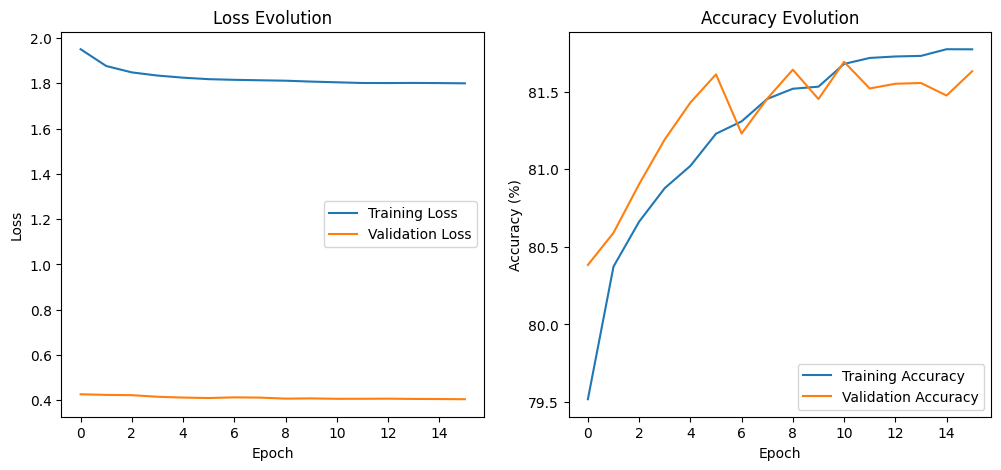

In [11]:
# Inicializar el modelo y moverlo al dispositivo
num_classes = len(set(train_labels.values()))
model_CNNGNN = CNNGNN(num_classes=num_classes,dropout_rate=0.6)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNNGNN.parameters(), lr=0.001, weight_decay=1e-5)
# Learning_rate scheduling
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Entrenamiento
train_model(model_CNNGNN, train_loader, num_epochs=100, batch_size=batch_size, learning_rate=0.001,criterion=criterion, optimizer=optimizer, scheduler=scheduler)

In [12]:
# Evaluar el modelo
labels, preds = evaluate_model(model_CNNGNN, test_loader)

# Mostrar el reporte de clasificación
print(classification_report(labels, preds, zero_division=0))

Precision: 0.8164, Recall: 0.8167, F1 Score: 0.8165
Confusion Matrix:
[[11190  1968]
 [ 2066  6779]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     13158
           1       0.78      0.77      0.77      8845

    accuracy                           0.82     22003
   macro avg       0.81      0.81      0.81     22003
weighted avg       0.82      0.82      0.82     22003



In [13]:
# Salvar el modelo
torch.save(model_CNNGNN.state_dict(), 'CNNGNN_resnet_2.pth')

# Calcular predicciones

In [14]:
# Cargar el archivo CSV
df = pd.read_csv("sample_submission.csv")

# Directorio donde están las imágenes
img_dir = "test"  # Reemplaza esto con la ruta correcta

# Realizar predicciones y actualizar el DataFrame
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Procesando imágenes", mininterval=1.0):
    img_path = os.path.join(img_dir, f"{row['id']}.tif")
    if os.path.exists(img_path):
        prediction = predict_image(img_path, model=model_CNNGNN)
        df.at[index, 'label'] = prediction
    else:
        print(f"Imagen no encontrada: {img_path}")

# Guardar el DataFrame actualizado
df.to_csv("updated_sample_submission_resnet_2.csv", index=False)

print("Predicciones completadas y guardadas en 'updated_sample_submission.csv'")

Procesando imágenes: 100%|██████████| 57458/57458 [20:03<00:00, 47.74it/s]

Predicciones completadas y guardadas en 'updated_sample_submission.csv'
